# Baseline Pipeline: YOLO → Pinhole → ResNet → 6D Pose
This minimal version runs the basic pipeline for 6D pose estimation on LineMOD, inspired by the notebook test5_baseline_pinhole_pipeline.ipynb.

**Note:** This minimal pipeline runs only one test batch and shows the predicted translation and rotation. For full evaluation and metrics, see the original notebook test5_baseline_pinhole_pipeline.ipynb.

## 1. Essential imports and minimal setup

In [1]:
# Essential imports and minimal setup
import sys
from pathlib import Path
import torch
import os
import pandas as pd

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from models.pose_estimator_baseline import PoseEstimatorBaseline
from models.yolo_detector import YOLODetector
from dataset.linemod_pose import create_pose_dataloaders
from utils.file_io import load_validation_results
from utils.visualization import plot_add_per_class, calc_add_accuracy_per_class
from utils.validation import run_yolo_baseline_pipeline
from utils.model_loader import load_model_checkpoint, ensure_model_available


## 2. Load pre-trained models (YOLO and PoseEstimatorBaseline)

In [ ]:
DATASET_DIR = Path(Config.DATASETS_DIR)
if not DATASET_DIR.exists():
    print("Dataset not found, start downloading...")
    from utils.download_dataset import download_linemod_dataset
    download_linemod_dataset()
else:
    print("Dataset LineMOD present.")

In [2]:
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

In [4]:
# Load pre-trained models (YOLO and PoseEstimator BaseLine)

# Load YOLO detector
yolo_checkpoint_path = ensure_model_available("yolo_train20", check_exists_only=True)
yolo_detector = YOLODetector(model_name=str(yolo_checkpoint_path), num_classes=Config.NUM_CLASSES)

# Load PoseEstimator BaseLine
NAME = "pose_rgb_baseline"
model_endtoend = PoseEstimatorBaseline(pretrained=True)
model_endtoend = load_model_checkpoint(NAME, model_endtoend, device=str(Config.DEVICE))
model_endtoend.eval()


Checkpoint found: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train20/weights/best.pt
Loading custom weights: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train20/weights/best.pt
PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (weights=ResNet50_Weights.IMAGENET1K_V1, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5


FileNotFoundError: Checkpoint not found and download failed: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/weights/best.pt
Error: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Download the checkpoints from GitHub or run training.

## 3. Full pipeline YOLO + ResNet + Pinhole

Evaluate the baseline BaseLine pipeline with YOLO detection on full-size images.  
You can choose between:
- **Quick debug**: 10 images (cell 4.1)
- **Full validation**: the entire test set (cell 4.2)

In [6]:
# 🐛 QUICK DEBUG: Test YOLO pipeline on only 10 images
# ✅ Use max_samples=10 for quick debug
run_yolo_baseline_pipeline(
    yolo_detector, 
    model_baseline, 
    test_loader, 
    name=POSE_MODEL_NAME,
    max_samples=10  # 🔧 Only 10 images for quick debug
)

print("\n💡 For full validation on the entire test set, run the next cell!")

Using model pose_rgb_baseline
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validazione YOLO pipeline (baseline, max 10 samples):   0%|          | 0/210 [00:03<?, ?it/s]

Samples processed: 10
Detection failures: 0
Concatenating batches...
Computing full 6D pose ADD metrics
Metrics computed
Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv
Results saved to /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv

💡 For full validation on the entire test set, run the next cell!


In [7]:
# 🚀 FULL VALIDATION: Run the baseline pipeline on the ENTIRE test set
# ⚠️ This cell may take several minutes. For quick debug use the previous cell (10 images)

# Process the entire test set (no limit)
run_yolo_baseline_pipeline(yolo_detector, model_baseline, test_loader, name=POSE_MODEL_NAME)

Using model pose_rgb_baseline
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validazione YOLO pipeline (baseline): 100%|██████████| 210/210 [50:52<00:00, 14.54s/it]

Samples processed: 13405
Detection failures: 2
Concatenating batches...
Computing full 6D pose ADD metrics


Metrics computed
Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv
Results saved to /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_baseline/validation_result.csv


## 4. Load and show per-class metrics table (ADD full pose)

In [8]:
# Load and show per-class metrics table (ADD full pose)
val_csv_path = os.path.join(Config.CHECKPOINT_DIR, 'pose', POSE_MODEL_NAME, 'validation_result.csv')
results_full_pose, _ = load_validation_results(val_csv_path)

data, global_add, global_acc = calc_add_accuracy_per_class(results_full_pose, Config.LINEMOD_OBJECTS)

df = pd.DataFrame(data)
display(df)
print(f"\nGlobal mean ADD (full pose): {global_add:.2f}")
print(f"Global accuracy (full pose) (%): {global_acc:.1f}")

,Class,ADD (mm),Accuracy (%)
0,01 - ape,14.04,40.5
1,02 - benchvise,50.65,29.0
2,04 - camera,29.99,37.3
3,05 - can,30.13,39.6
4,06 - cat,20.04,47.6
5,08 - driller,29.03,56.8
6,09 - duck,25.22,24.1
7,10 - eggbox,6.94,100.0
8,11 - glue,6.44,99.2
9,12 - holepuncher,20.37,45.6



Global mean ADD (full pose): 26.63
Global accuracy (full pose) (%): 50.7


## 5. Bar chart of mean ADD per class (rot-only)
Shows the means of the ADD metric for each object class, calculated on the predicted rotation.

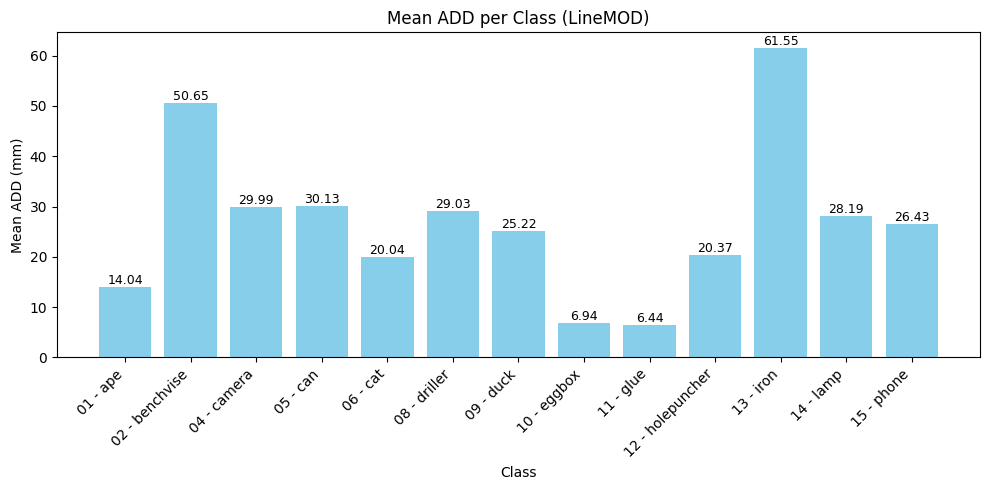

In [ ]:
# Bar chart of mean ADD per class (full pose BaseLine)
results_full_pose = globals().get('results_full_pose', None)
if results_full_pose is None:
    print("⚠️  You must first compute the ADD full pose metric on the entire test set and save the results in 'results_full_pose'.")
else:
    plot_add_per_class(results_full_pose, Config.LINEMOD_OBJECTS)